In [1]:
from loadphantom import BreastPhantomReader
file_path = "../../data/breast/class2/phantom1/"
reader = BreastPhantomReader(file_path)

Phantom ID 012204 loaded successfully.
Dimensions (s1, s2, s3): (316, 352, 307)
Classification: 2


In [2]:
freq = 1. # GHz
epsilon_rb = 10.
sigma_b = 0.

reader.set_immersion_medium_properties(dielectric_constant=epsilon_rb,
                                       conductivity=sigma_b)

epsilon_r, sigma = reader.calculate_dielectric_properties(
    freq, model='debye'
)

Immersion medium properties set: εr=10.0, σ=0.0 S/m


In [3]:
import numpy as np
# Find locations where relative permittivity equals zero
zero_locations = (epsilon_r == 0)
print(f"Found {zero_locations.sum()} locations with epsilon_r = 0")

# Get the material type at those locations
if zero_locations.any():
    # Find the first occurrence of zero permittivity
    zero_indices = np.where(zero_locations)
    first_zero_idx = (zero_indices[0][0], zero_indices[1][0], zero_indices[2][0])
    
    # Check the material type at that location
    material_type = reader.mtype_grid[first_zero_idx]
    print(f"Material type at zero permittivity location {first_zero_idx}: {material_type}")
    
    # Check what this material type represents
    print(f"Material type value: {material_type}")
else:
    print("No locations with epsilon_r = 0 found")

Found 0 locations with epsilon_r = 0
No locations with epsilon_r = 0 found


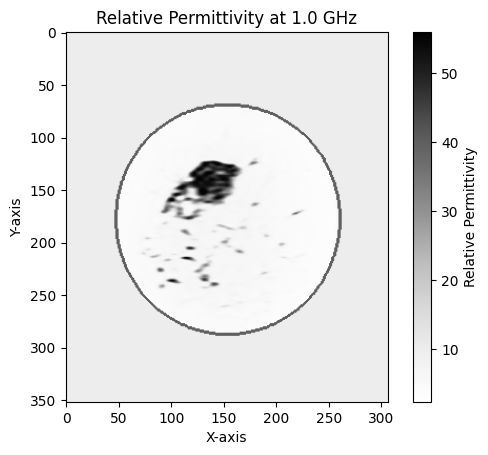

In [4]:
from matplotlib import pyplot as plt
plt.imshow(epsilon_r[140, :, :], cmap='Greys')
plt.colorbar(label='Relative Permittivity')
plt.title(f'Relative Permittivity at {freq} GHz')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

Degrees of freedom: 25


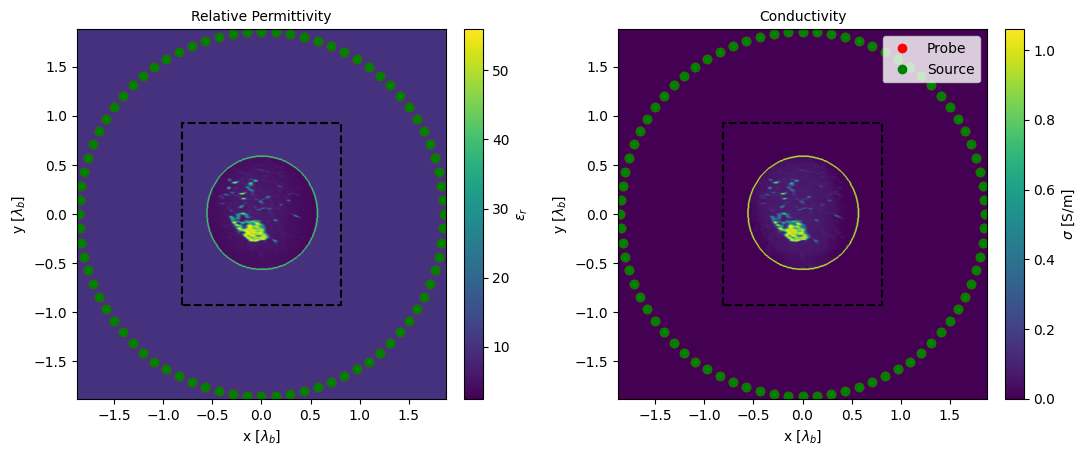

In [5]:
import numpy as np
import sys
sys.path.insert(1, '../../eispy2d/library/')
import configuration as cfg

epsr = np.squeeze(epsilon_r[140, :, :])
sig = np.squeeze(sigma[140, :, :])

instance_name = 'breastphantom'
dx = dy = 0.5e-3 # 0.5 mm
Lx, Ly = epsr.shape[1] * dx, epsr.shape[0] * dy
max_epsilon_r = epsr.max()
object_radius = min([Lx, Ly]) / 2.0
DOF = cfg.degrees_of_freedom(object_radius, frequency=freq*1e9,
                             epsilon_r=max_epsilon_r)
print(f"Degrees of freedom: {DOF}")
NS = NM = 80
Ro = max([Lx, Ly])
image_size = [Ly, Lx]
E0 = 1.

config = cfg.Configuration(name=instance_name + '.cfg',
                           number_measurements=NM,
                           number_sources=NS,
                           observation_radius=Ro,
                           frequency=freq*1e9,
                           background_permittivity=epsilon_rb,
                           background_conductivity=sigma_b,
                           image_size=image_size,
                           wavelength_unit=False,
                           magnitude=E0)

config.draw(epsr=epsr, sig=sig, show=True)

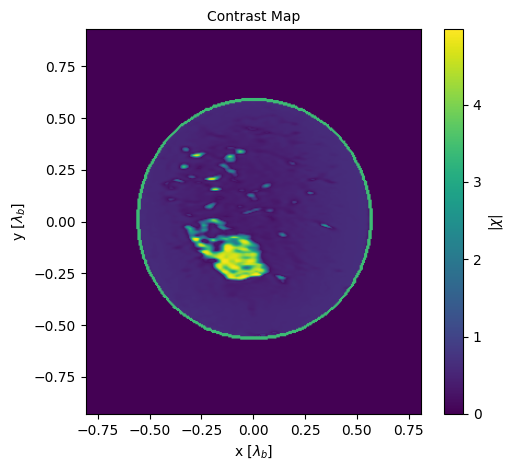

Input name: breastphantom.ipt
Configuration file: breastphantom.cfg
Images Resolution: 352x307
Relative Permit. map shape: 352x307
Conductivity map shape: 352x307
Indicators: ['zeta_s', 'zeta_p', 'objective_function']
Degrees of Non-Linearity: None


In [6]:
import inputdata as ipt
import result as rst

test = ipt.InputData(name=instance_name + '.ipt',
                     configuration=config,
                     rel_permittivity=epsr,
                     conductivity=sig,
                     indicators=[rst.SHAPE_ERROR, rst.POSITION_ERROR,
                                 rst.OBJECTIVE_FUNCTION])

# test.compute_dnl()
test.draw(show=True, image=ipt.CONTRAST)
print(test)

In [8]:
# import mom_cg_fft as mom
# forward = mom.MoM_CG_FFT(tolerance=1e-3, maximum_iterations=5_000)
# _ = forward.solve(test)

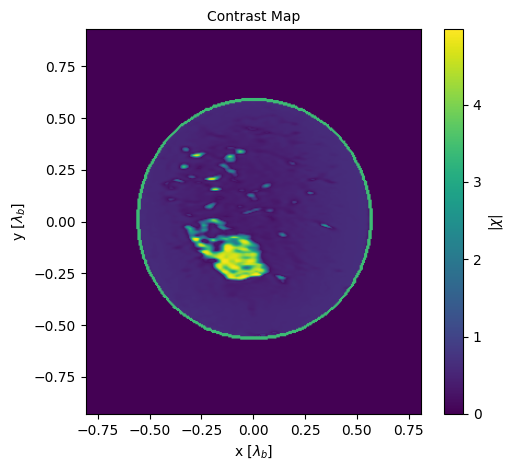

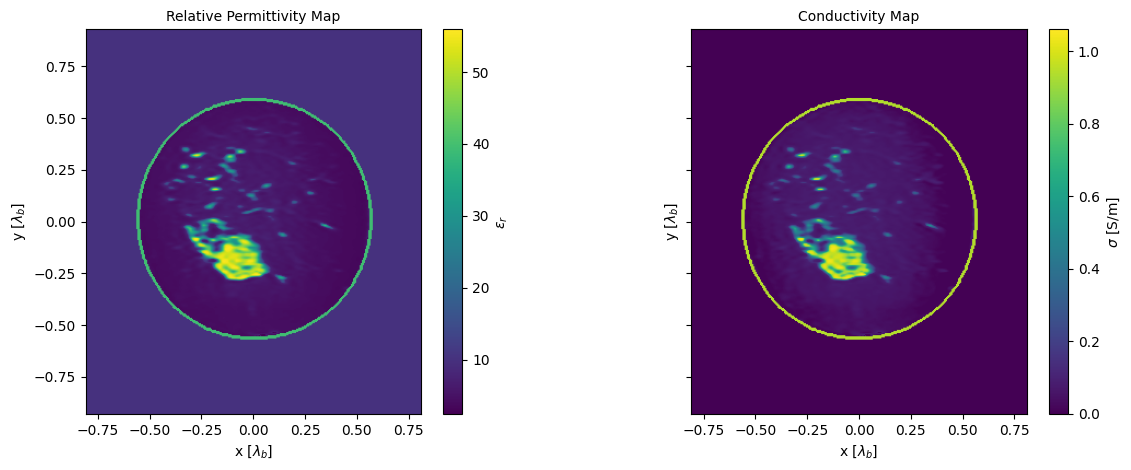

Input name: breastphantom.ipt
Configuration file: breastphantom.cfg
Images Resolution: 352x307
Scattered field - measurement samples: 80
Scattered field - source samples: 80
Total field - measurement samples: 108064
Total field - source samples: 80
Relative Permit. map shape: 352x307
Conductivity map shape: 352x307
Indicators: ['zeta_s', 'zeta_p', 'objective_function']
Degrees of Non-Linearity: 0.0126


In [7]:
import inputdata as ipt
import richmond as ric
resolution = (40, 40)
test = ipt.InputData(import_filename=instance_name + '.ipt',
                     import_filepath='../../data/breast/class2/phantom1/')
discretization = ric.Richmond(configuration=test.configuration,
                              elements=resolution)
test.draw(show=True)
test.draw(show=True, image=ipt.BOTH_PROPERTIES)
print(test)

Method: Subspace-based Optimization Method
Alias: som
Input Data: breastphantom.ipt
Discretization: Richmond Method (80x80)
Method of Moments - CG-FFT (iterations=5000, tolerance=1.0e-03)
Stop Criteria
Maximum number of iterations: 100
Iteration: 1 -  Shape: 165.53, Position: 7.81, Ob. Func.: 2.869e+01,
Iteration: 2 -  Shape: 152.59, Position: 7.42, Ob. Func.: 1.970e+01,
Iteration: 3 -  Shape: 149.94, Position: 6.86, Ob. Func.: 1.352e+01,
Iteration: 4 -  Shape: 139.99, Position: 6.63, Ob. Func.: 9.775e+00,
Iteration: 5 -  Shape: 133.47, Position: 6.85, Ob. Func.: 7.404e+00,
Iteration: 6 -  Shape: 127.63, Position: 7.33, Ob. Func.: 5.930e+00,
Iteration: 7 -  Shape: 122.54, Position: 7.86, Ob. Func.: 4.838e+00,
Iteration: 8 -  Shape: 117.25, Position: 8.47, Ob. Func.: 4.096e+00,
Iteration: 9 -  Shape: 114.60, Position: 8.82, Ob. Func.: 3.531e+00,
Iteration: 10 -  Shape: 110.00, Position: 9.53, Ob. Func.: 3.109e+00,
Iteration: 20 -  Shape: 101.16, Position: 10.70, Ob. Func.: 1.392e+00,
It

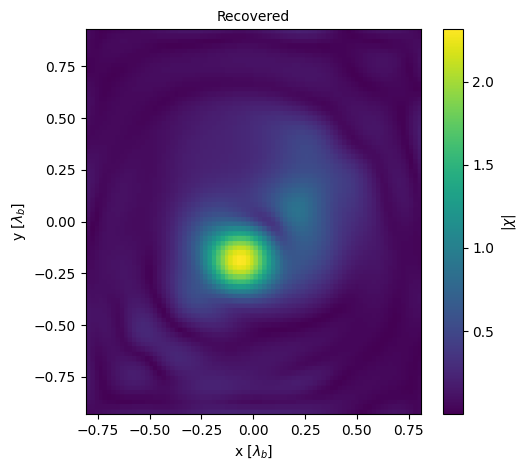

In [26]:
import som
import stopcriteria as stp

resolution = (80, 80)
discretization = ric.Richmond(configuration=test.configuration,
                              elements=resolution)

method = som.SubspaceBasedOptimizationMethod(
    stp.StopCriteria(max_iterations=100), cutoff_index=15
)

result = method.solve(test, discretization)

result.plot_map(show=True)

Threshold value: 3.481602752979449
Threshold value: 0.5


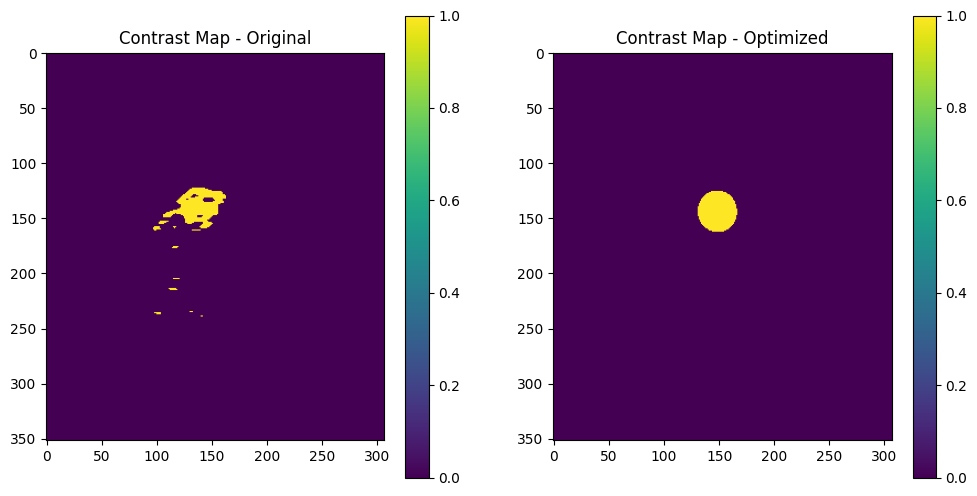

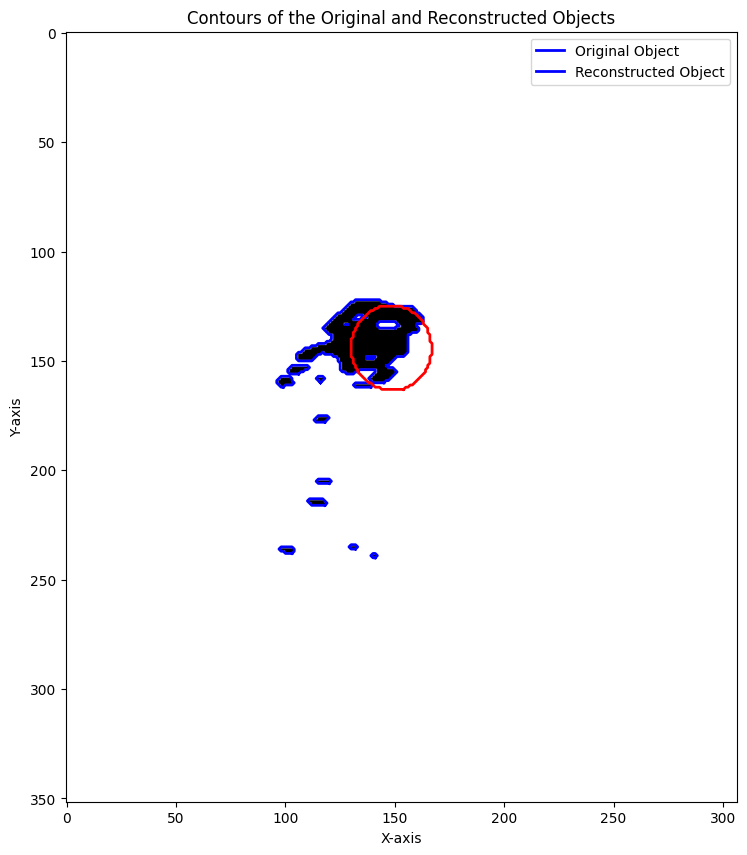

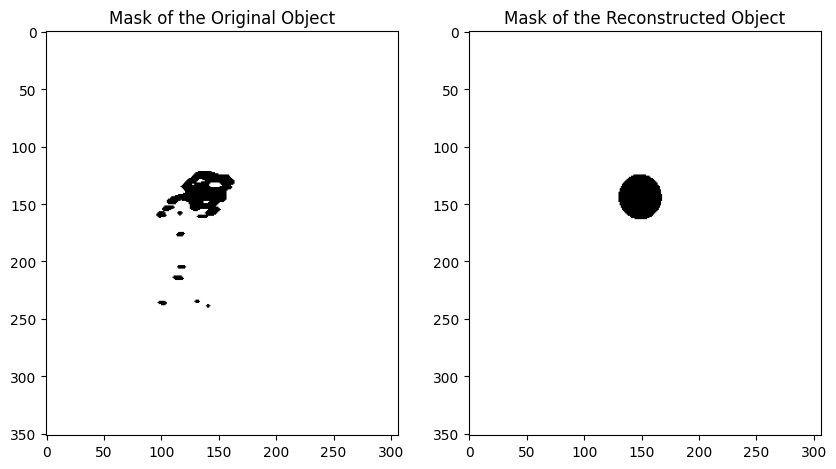

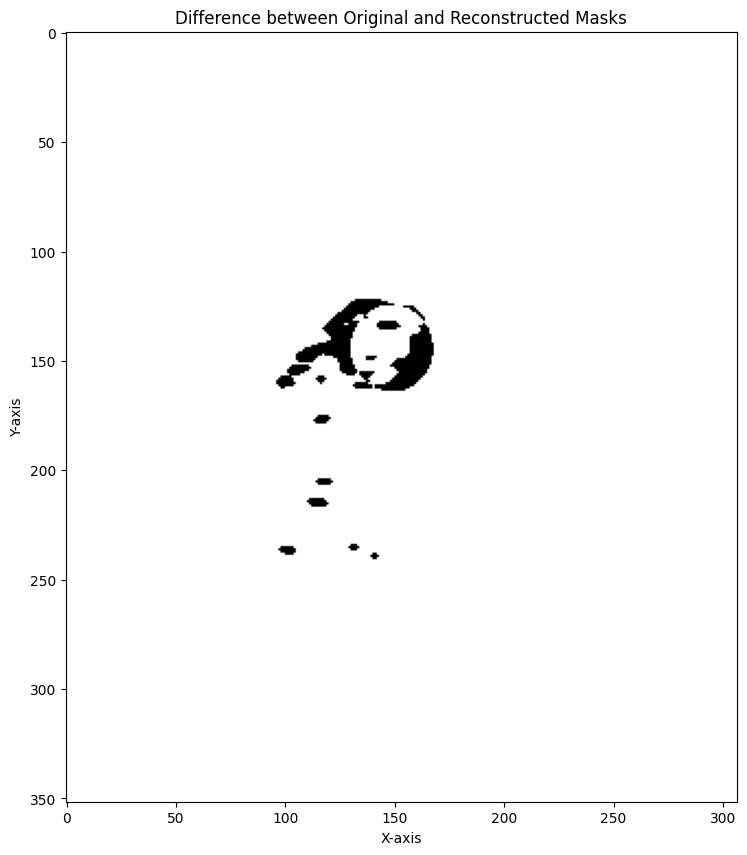

Area difference between original and reconstructed masks: 78.62%


In [54]:
Xo = cfg.get_contrast_map(epsilon_r=test.rel_permittivity,
                          sigma=test.conductivity,
                          configuration=test.configuration)
Xo = np.abs(Xo)
threshold2 = (np.amin(Xo) + 0.7*(np.amax(Xo)-np.amin(Xo)))
print(f"Threshold value: {threshold2}")

Xr = cfg.get_contrast_map(epsilon_r=result.rel_permittivity,
                            sigma=result.conductivity,
                            configuration=result.configuration)
Xr = np.abs(Xr)
threshold = (np.amin(Xr) + 0.5*(np.amax(Xr)-np.amin(Xr)))
print(f"Threshold value: {threshold}")


Xo[Xo <= threshold2] = 0
Xo[Xo > threshold2] = 1
Xr[Xr <= threshold] = 0
Xr[Xr > threshold] = 1

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Contrast Map - Original')
plt.imshow(Xo)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.title('Contrast Map - Optimized')
plt.imshow(Xr)
plt.colorbar()
plt.show()


from skimage import measure

co = measure.find_contours(Xo, .0, fully_connected='high')
cr = measure.find_contours(Xr, .0, fully_connected='high')

for i in range(len(cr)):
    cr[i][:, 1] = Xo.shape[1]*cr[i][:, 1]/Xr.shape[1]
    cr[i][:, 0] = Xo.shape[0]*cr[i][:, 0]/Xr.shape[0]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(Xo, cmap='Greys', vmin=0, vmax=1)
for i in range(len(co)):
    plt.plot(co[i][:, 1], co[i][:, 0], linewidth=2, color='blue')
for i in range(len(cr)):
    plt.plot(cr[i][:, 1], cr[i][:, 0], linewidth=2, color='red')
plt.title('Contours of the Original and Reconstructed Objects')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(['Original Object', 'Reconstructed Object'])
plt.show()

masko = np.zeros(Xo.shape, dtype=bool)
counter = np.zeros(Xo.shape)
for i in range(len(co)):
    maskt = measure.grid_points_in_poly(Xo.shape, co[i])
    counter[maskt] += 1
masko[np.mod(counter, 2) == 1] = True

maskr = np.zeros(Xo.shape, dtype=bool)
counter = np.zeros(Xo.shape)
for i in range(len(cr)):
    maskt = measure.grid_points_in_poly(Xo.shape, cr[i])
    counter[maskt] += 1
maskr[np.mod(counter, 2) == 1] = True

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(masko, cmap='Greys')
plt.title('Mask of the Original Object')
plt.subplot(1, 2, 2)
plt.imshow(maskr, cmap='Greys')
plt.title('Mask of the Reconstructed Object')
plt.show()

diff = np.logical_xor(masko, maskr)
plt.figure(figsize=(10, 10))
plt.imshow(diff, cmap='Greys')
plt.title('Difference between Original and Reconstructed Masks')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

area_diff = np.sum(diff)/np.sum(masko)*100
print(f"Area difference between original and reconstructed masks: {area_diff:.2f}%")

Method: Born Iterative Method
Alias: bim
Input Data: breastphantom.ipt
Discretization: Richmond Method (80x80)
Method of Moments - CG-FFT (iterations=5000, tolerance=1.0e-03)
Regularization Method: Tikhonov
Choice strategy: fixed
Parameter value: 1.000e+01
Stop Criteria
Maximum number of iterations: 10
Iteration: 1 -  Shape: 104.29, Position: 8.00, Ob. Func.: 3.146e+05,
Iteration: 2 -  Shape: 268.53, Position: 4.88, Ob. Func.: 2.217e+05,
Iteration: 3 -  Shape: 136.27, Position: 3.87, Ob. Func.: 1.648e+05,
Iteration: 4 -  Shape: 102.04, Position: 9.36, Ob. Func.: 1.611e+05,
Iteration: 5 -  Shape: 103.89, Position: 5.05, Ob. Func.: 1.229e+05,
Iteration: 6 -  Shape: 88.40, Position: 11.21, Ob. Func.: 1.251e+05,
Iteration: 7 -  Shape: 83.31, Position: 11.17, Ob. Func.: 1.159e+05,
Iteration: 8 -  Shape: 84.06, Position: 11.80, Ob. Func.: 1.085e+05,
Iteration: 9 -  Shape: 84.29, Position: 12.07, Ob. Func.: 1.183e+05,
Iteration: 10 -  Shape: 80.75, Position: 11.72, Ob. Func.: 1.100e+05,


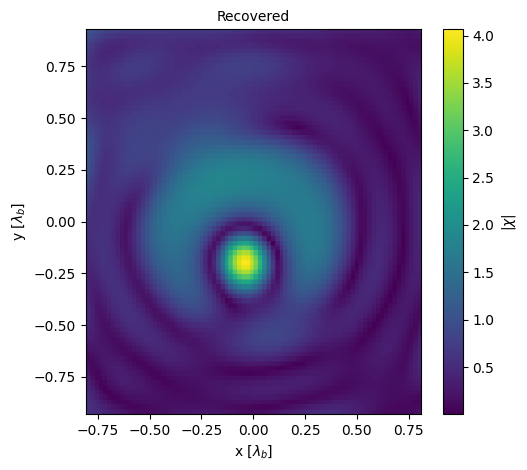

In [34]:
import bim
import stopcriteria as stp
import regularization as reg
import mom_cg_fft as mom

method = bim.BornIterativeMethod(mom.MoM_CG_FFT(),
                                 reg.Tikhonov(reg.TIK_FIXED, parameter=1e1),
                                 stp.StopCriteria(max_iterations=10))

result = method.solve(test, discretization)

result.plot_map(show=True)

In [35]:
import csi

method = csi.ContrastSourceInversion(stp.StopCriteria(max_iterations=500))

result = method.solve(test, discretization)

result.plot_map(show=True)

Method: Contrast Source Inversion
Alias: csi
Input Data: breastphantom.ipt
Discretization: Richmond Method (80x80)
Method of Moments - CG-FFT (iterations=5000, tolerance=1.0e-03)
Stop Criteria
Maximum number of iterations: 500
Iteration: 1 -  Shape: 189.31, Position: 13.14, Ob. Func.: 1.938e+00,
Iteration: 2 -  Shape: 188.93, Position: 13.13, Ob. Func.: 1.215e+00,
Iteration: 3 -  Shape: 188.93, Position: 13.13, Ob. Func.: 1.204e+00,
Iteration: 4 -  Shape: 188.93, Position: 13.13, Ob. Func.: 1.194e+00,
Iteration: 5 -  Shape: 188.93, Position: 13.13, Ob. Func.: 1.184e+00,
Iteration: 6 -  Shape: 188.80, Position: 13.18, Ob. Func.: 1.174e+00,
Iteration: 7 -  Shape: 188.80, Position: 13.18, Ob. Func.: 1.165e+00,
Iteration: 8 -  Shape: 188.80, Position: 13.18, Ob. Func.: 1.155e+00,
Iteration: 9 -  Shape: 188.78, Position: 13.19, Ob. Func.: 1.147e+00,
Iteration: 10 -  Shape: 188.78, Position: 13.19, Ob. Func.: 1.138e+00,
Iteration: 20 -  Shape: 187.98, Position: 13.08, Ob. Func.: 1.065e+00,
I

KeyboardInterrupt: 

Method: Linear Sampling Method
Alias: lsm
Input Data: breastphantom.ipt
Discretization: Richmond Method (80x80)
Regularization Method: Tikhonov
Choice strategy: fixed
Parameter value: 1.000e+00
Threshold: 0.95
Field approximation: automatic
Indicator function: standard
Results name: breastphantom.ipt_lsm
Configuration: breastphantom.cfg
Relative Permit. map resolution: 352x307
Conductivity map resolution: 352x307
Position error: 9.34%
Shape error: 87.15%


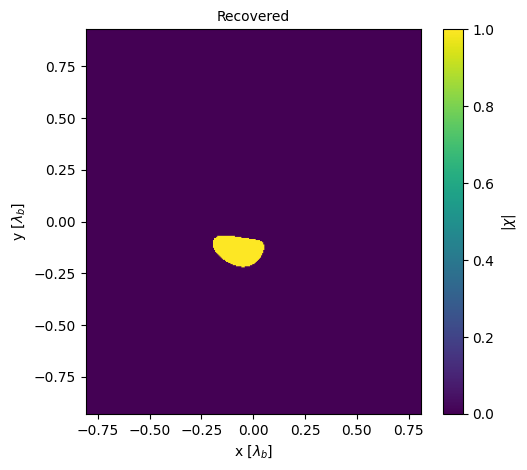

In [45]:
import lsm

method = lsm.LinearSamplingMethod(alias='lsm',
                                  regularization=reg.Tikhonov(reg.TIK_FIXED, parameter=1e0),
                            #  regularization=reg.ConjugatedGradient(300),
                             sv_cutoff=None, threshold=.95)

result = method.solve(test, discretization)
print(result)
result.plot_map(show=True)



Method: Orthogonality Sampling Method
Alias: osm
Input Data: breastphantom.ipt
Discretization: Richmond Method (80x80)
Threshold: 0.90
Results name: breastphantom.ipt_osm
Configuration: breastphantom.cfg
Relative Permit. map resolution: 352x307
Conductivity map resolution: 352x307
Position error: 9.73%
Shape error: 87.49%


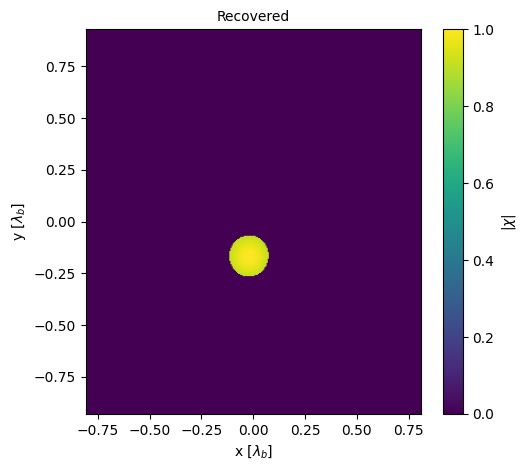

In [49]:
import osm

method = osm.OrthogonalitySamplingMethod(threshold=.90)

result = method.solve(test, discretization)
print(result)
result.plot_map(show=True)



